In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import sys
sys.path.insert(0,'drive/Fast-Pytorch/Learning_Pytorch')
!ls drive

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [0]:
# Data Augmentation
#normalize the image with std and mean
#e.g: input[channel]=(input[channel]-mean[channel])/std(channel)
data_transforms ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # mean[.,.,.], std[]
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

In [0]:
data_dir='drive/Fast-Pytorch/Learning_Pytorch/datasets/hymenoptera_data'
batchsize=4
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x]) for x in ['train','val']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x], 
                                            batch_size=batchsize, 
                                            shuffle=True) for x in ['train','val']}
dataset_sizes ={x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

print("Class Names: {}".format(class_names))
print("Training set: number of batches={}".format(len(dataloaders['train'])))
print("Test set: number of batches={}".format(len(dataloaders['val'])))
print("Number of images in training={}".format(dataset_sizes['train']))
print("Number of images in test={}".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
Training set: number of batches=61
Test set: number of batches=39
Number of images in training=244
Number of images in test=153


In [0]:
# load pre-trained model
model_conv=torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 79276811.10it/s]


In [0]:
# freeze all layers
for param in model_conv.parameters():
  param.requires_grad= False

In [0]:
# get the number of inputs of the last layer
num_ftrs = model_conv.fc.in_features
#reconstruct last layer to have only two classes
model_conv.fc= nn.Linear(num_ftrs,2)

In [0]:
if torch.cuda.is_available():
  model_conv=model_conv.cuda()

In [0]:
iteration=0
correct=0
for inputs,labels in dataloaders['train']:
  if iteration==1:
    break
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()
  print("Input shape:", inputs.shape)
  print("Label shape:", labels.shape)
  print("Labels are: {}".format(labels))
  output=model_conv(inputs)
  print("Output Tensor:", output)
  print("Output Shape:", output.shape)
  _, predicted=torch.max(output,1)
  print("Predicted:", predicted)
  print("Predicted Shape:", predicted.shape)
  correct+=(predicted==labels).sum()
  print("Correct Predictions:", correct)
  
  iteration+=1

Input shape: torch.Size([4, 3, 224, 224])
Label shape: torch.Size([4])
Labels are: tensor([1, 1, 0, 0], device='cuda:0')
Output Tensor: tensor([[ 0.1782, -0.1286],
        [ 1.0275, -0.0146],
        [-0.0431,  0.0178],
        [ 0.1485,  0.2718]], device='cuda:0', grad_fn=<AddmmBackward>)
Output Shape: torch.Size([4, 2])
Predicted: tensor([0, 0, 1, 1], device='cuda:0')
Predicted Shape: torch.Size([4])
Correct Predictions: tensor(0, device='cuda:0')


In [0]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
num_epochs=25
for epoch in range(num_epochs):
  exp_lr_scheduler.step()
  correct=0
  for images, labels in dataloaders['train']:
    images=Variable(images)
    labels=Variable(labels)
    if torch.cuda.is_available():
      images=images.cuda()
      labels=labels.cuda()
      
    optimizer.zero_grad()
    outputs=model_conv(images)
    loss= criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    _,predicted=torch.max(outputs,1)
    correct +=(predicted==labels).sum()
  
  train_acc =100*correct/dataset_sizes['train']
  print('Epoch [{}/{}], Loss:{:.4f}, Train_Accuracy:{}%'
       .format(epoch+1,num_epochs,loss.item(),train_acc))

Epoch [1/25], Loss:0.4079, Train_Accuracy:65%
Epoch [2/25], Loss:0.2373, Train_Accuracy:82%
Epoch [3/25], Loss:0.8983, Train_Accuracy:83%
Epoch [4/25], Loss:0.1289, Train_Accuracy:73%
Epoch [5/25], Loss:0.7270, Train_Accuracy:78%
Epoch [6/25], Loss:0.0582, Train_Accuracy:81%
Epoch [7/25], Loss:0.1058, Train_Accuracy:84%
Epoch [8/25], Loss:0.1020, Train_Accuracy:85%
Epoch [9/25], Loss:0.4327, Train_Accuracy:85%
Epoch [10/25], Loss:0.0438, Train_Accuracy:84%
Epoch [11/25], Loss:0.4448, Train_Accuracy:83%
Epoch [12/25], Loss:0.1385, Train_Accuracy:87%
Epoch [13/25], Loss:0.4898, Train_Accuracy:81%
Epoch [14/25], Loss:0.1892, Train_Accuracy:81%
Epoch [15/25], Loss:0.1088, Train_Accuracy:83%
Epoch [16/25], Loss:0.0406, Train_Accuracy:86%
Epoch [17/25], Loss:0.0101, Train_Accuracy:84%
Epoch [18/25], Loss:0.2505, Train_Accuracy:81%
Epoch [19/25], Loss:0.1173, Train_Accuracy:86%
Epoch [20/25], Loss:0.1423, Train_Accuracy:85%
Epoch [21/25], Loss:0.3028, Train_Accuracy:87%
Epoch [22/25], Loss:0.

In [0]:
# Test model
model_conv.eval()
with torch.no_grad():
  correct=0
  total=0
  for (images,labels) in dataloaders['val']:
    images=Variable(images)
    labels=Variable(labels)
    if torch.cuda.is_available():
      images=images.cuda()
      labels=labels.cuda()
    
    outputs=model_conv(images)
    _,predicted= torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
  
  print("Test Accuracy: {:.3f}%".format(100*correct/total))

Test Accuracy: 94.118%


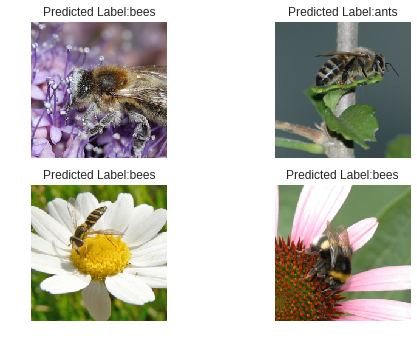

In [0]:
import matplotlib.pyplot as plt
fig=plt.figure()
shown_batch=0
index=0
with torch.no_grad():
  for (images,labels) in dataloaders['val']:
    if shown_batch==1:
      break
    shown_batch+=1
    images=Variable(images)
    labels=Variable(labels)
    if torch.cuda.is_available():
      images=images.cuda()
      labels=labels.cuda()
    
    outputs=model_conv(images)
    _,predictions=torch.max(outputs,1)
    
    for i in range(4):
      index+=1
      ax=plt.subplot(2,2,index)
      ax.axis('off')
      ax.set_title("Predicted Label:{}".format(class_names[predictions[i]]))
      input_img=images.cpu().data[i]
      inp=input_img.numpy().transpose((1,2,0))
      mean=np.array([0.485,0.456,0.406])
      std=np.array([0.229,0.224,0.225])
      inp=std*inp+mean
      inp=np.clip(inp,0,1)
      plt.imshow(inp)